<a href="https://colab.research.google.com/github/alisha-17kakkar/hERG---project/blob/main/hERG---project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install rdkit-pypi pandas scikit-learn matplotlib chembl_webresource_client

In [17]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import os
filename = "herg_activity_data.csv"
if os.path.exists(filename):
    print(f"Loading data from local file: {filename} ...")
    df = pd.read_csv(filename)
    print("Data loaded instantly!")
else:
    print(f"Local file not found. Downloading data from ChEMBL for the first time...")
    print("(This might take a minute or two, but will only happen once.)")
    target = new_client.target
    target_query = target.search('herg')
    targets = pd.DataFrame.from_dict(target_query)
    human_herg_target = targets[targets['target_chembl_id'] == 'CHEMBL240']
    target_id = human_herg_target.target_chembl_id.values[0]
    activity = new_client.activity
    res = activity.filter(target_chembl_id=target_id).filter(standard_type="IC50")
    df = pd.DataFrame.from_dict(res)
    df.to_csv(filename, index=False)
    print(f"Data downloaded and saved to {filename} for fast future access.")
print("-----------------------------------------")
print(f"Shape of the dataset: {df.shape}")
df.head()

Loading data from local file: herg_activity_data.csv ...
Data loaded instantly!
-----------------------------------------
Shape of the dataset: (16074, 46)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,NaN,305156,[],CHEMBL841079,Inhibition of hERG currents Kv11.1,T,NaN,NaN,BAO_0000190,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,14.0
1,NaN,NaN,305157,[],CHEMBL841078,Inhibitory concentration against hERG currents...,F,NaN,NaN,BAO_0000190,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3.0
2,NaN,NaN,305244,[],CHEMBL691014,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,32.2
3,NaN,NaN,305245,[],CHEMBL691013,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,5950.0
4,NaN,NaN,306561,[],CHEMBL691014,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,143.0


In [14]:
df_clean = df[['canonical_smiles', 'standard_value']]
df_clean = df_clean.dropna()
df_clean['standard_value'] = pd.to_numeric(df_clean['standard_value'], errors='coerce')
df_clean = df_clean.dropna()
print(f"Shape after cleaning: {df_clean.shape}")
df_clean.head()

Shape after cleaning: (14167, 2)


,canonical_smiles,standard_value
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,14.0
1,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,3.0
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,32.2
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,5950.0
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,143.0


In [15]:
bioactivity_class = []
for value in df_clean['standard_value']:
  if float(value) <= 10000:
    bioactivity_class.append("active")
  else:
    bioactivity_class.append("inactive")
df_clean['bioactivity_class'] = bioactivity_class
print(f"Final shape of our dataset: {df_clean.shape}")
print("\nValue counts for each class:")
print(df_clean['bioactivity_class'].value_counts())
df_clean.head()

Final shape of our dataset: (14167, 3)

Value counts for each class:
bioactivity_class
active      7956
inactive    6211
Name: count, dtype: int64


,canonical_smiles,standard_value,bioactivity_class
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,14.0,active
1,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,3.0,active
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,32.2,active
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,5950.0,active
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,143.0,active


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()
def generate_fingerprint(smiles_string):
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        return list(fp)
    else:
        return None

df_clean['fingerprint'] = df_clean['canonical_smiles'].progress_apply(generate_fingerprint)

df_final = df_clean.dropna(subset=['fingerprint']).copy()
X = np.array(df_final['fingerprint'].tolist())

y = df_final['bioactivity_class']

print("\nFingerprint generation complete!")
print("Shape of our features (X):", X.shape)
print("Shape of our target (y):", y.shape)

  0%|          | 0/14167 [00:00<?, ?it/s]


Fingerprint generation complete!
Shape of our features (X): (14167, 2048)
Shape of our target (y): (14167,)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model training complete!")


Model training complete!


Model Accuracy: 81.83%

Classification Report:
              precision    recall  f1-score   support

      active       0.84      0.84      0.84      1609
    inactive       0.79      0.79      0.79      1225

    accuracy                           0.82      2834
   macro avg       0.82      0.81      0.81      2834
weighted avg       0.82      0.82      0.82      2834


Confusion Matrix:


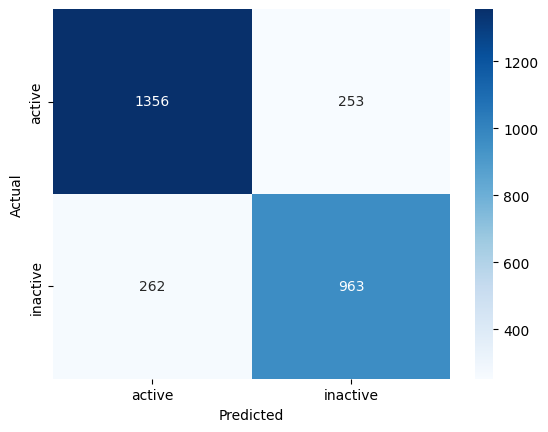

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['active', 'inactive'], yticklabels=['active', 'inactive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()